# Exploratory Data Analysis
* Geographical map of observations
* Extract information from vectorizers (TF-IDF and Count)
* group_by: keyword

In [1]:
import numpy as np
import pandas as pd
from joblib import dump, load
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from tqdm import tqdm
import geopandas as gpd
import geodatasets
from pickle import load, dump

ModuleNotFoundError: No module named 'wordcloud'

We will first load in the saved objects, including both the vectorizers and the associated training datasets

In [ ]:
# Load in TF-IDF and Count Vectorizers and training datasets
X_train_tfidf = load("../joblib_files/X_train_tfidf.joblib")
X_train_count = load("../joblib_files/X_train_count.joblib")
tfidf_vectorizer = load("../pkl_files/tfidf_vectorizer.pkl")
count_vectorizer = load("../pkl_files/count_vectorizer.pkl")

# Load in clean train and test sets
clean_train = pd.read_pickle("../pkl_files/clean_train.pkl")
clean_test = pd.read_pickle("../pkl_filesclean_test.pkl")

Sorted counts of both keyword and location

In [ ]:
keyword_counts = clean_train.groupby('keyword').size().reset_index(name = 'count')
keyword_counts = keyword_counts.sort_values(by = 'count', ascending = False)
print("Top 10 Keyords by Frequency Count", keyword_counts[:10])

location_counts = clean_train.groupby('location').size().reset_index(name = 'count')
location_counts = location_counts.sort_values(by = 'count', ascending = False)
print("Top 10 Locations by Frequency Count", location_counts[:10])

Top 10 Keyords by Frequency Count          keyword  count
145      missing     61
104   fatalities     45
63        deluge     42
8     armageddon     42
29   body%20bags     41
178      sinking     41
57        damage     41
119         harm     41
216    windstorm     40
154     outbreak     40
Top 10 Locations by Frequency Count              location  count
3119          missing   2533
2643              USA    104
1826         New York     71
2662    United States     50
1506           London     45
587            Canada     29
1860          Nigeria     28
2632               UK     27
1534  Los Angeles, CA     26
1262            India     24


Geographical analysis (may remove)

In [ ]:
geolocator = Nominatim(user_agent="geo_disaster_tweets")

def get_country(location):
    try:
        geo = geolocator.geocode(location, timeout=10)
        if geo:
            return geo.address.split(",")[-1].strip()  # Extract country
    except:
        return None
    return None

# Apply function to first 100 unique locations (to avoid API limits)
unique_locations = clean_train['location'].dropna().unique()[:100]
location_to_country = {loc: get_country(loc) for loc in tqdm(unique_locations)}

# Map countries back to dataset
clean_train['country'] = clean_train['location'].map(location_to_country)

100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


In [ ]:
country_counts = clean_train['country'].value_counts().reset_index()
country_counts.columns = ['country', 'tweet_count']
print(country_counts.head())

                                             country  tweet_count
0                                             France         2534
1                                      United States          258
2                                             Canada           47
3                                              India           29
4  Ködörösêse tî Bêafrîka / République centrafric...           27


Extracted vocabulary/features from vectorizers

In [ ]:
# Get feature names (words)
count_features = count_vectorizer.get_feature_names_out()
tfidf_features = tfidf_vectorizer.get_feature_names_out()

print("Sample CountVectorizer features:", count_features)
print("Sample TF-IDF features:", tfidf_features)

Sample CountVectorizer features: ['00' '000' '0000' ... 'ûónegligence' 'ûótech' 'ûówe']
Sample TF-IDF features: ['00' '000' '0000' ... 'ûónegligence' 'ûótech' 'ûówe']


As you can see, many of the features are noisy, such as IDs, hashes, and other random features. We will now extract the most frequent words and most relevant words, based on the CountVectorizer and TF-IDF Vectorizer approaches, respectively.

In [ ]:
# Sum word occurrences
word_counts = np.asarray(X_train_count.sum(axis=0)).flatten()

# Create df with words and their frequencies
word_freq_df = pd.DataFrame({'word': count_features, 'count': word_counts})

# Sort by frequency
word_freq_df = word_freq_df.sort_values(by='count', ascending=False)

print("Top 10 most frequent words: ", word_freq_df[:10])

Top 10 most frequent words:              word  count
10025       http   4312
13516    missing   2637
14236        new    438
10026      https    411
12343       like    351
23154         û_    348
2142         amp    344
11346       just    324
21241        usa    281
7145   emergency    263


In [ ]:
# Sum TF-IDF scores
tfidf_weights = np.asarray(X_train_tfidf.sum(axis=0)).flatten()

# Create df with words and their TF-IDF scores
tfidf_df = pd.DataFrame({'word': tfidf_features, 'tfidf': tfidf_weights})

# Sort by importance
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False)

print("Top 10 most important words: ", tfidf_df[:10])

Top 10 most important words:              word       tfidf
10025       http  274.055745
13516    missing  234.015484
10026      https   61.866688
14236        new   60.780380
12343       like   56.890282
11346       just   52.855225
2142         amp   49.082309
23154         û_   46.297441
21241        usa   44.735939
7145   emergency   44.706812


Now we will look at the importance of words/features, in relation to if they are a real vs. fake disaster tweet

In [ ]:
# Separate real and fake tweets
real_tweets = clean_train[clean_train['target'] == 1]['text']
fake_tweets = clean_train[clean_train['target'] == 0]['text']

# Vectorize separately
X_real_tfidf = tfidf_vectorizer.transform(real_tweets)
X_fake_tfidf = tfidf_vectorizer.transform(fake_tweets)

# Compute sum of TF-IDF scores per word
real_tfidf_scores = np.asarray(X_real_tfidf.sum(axis=0)).flatten()
fake_tfidf_scores = np.asarray(X_fake_tfidf.sum(axis=0)).flatten()

# Create DataFrame
word_comparison_df = pd.DataFrame({
    'word': tfidf_features,
    'real_tfidf': real_tfidf_scores,
    'fake_tfidf': fake_tfidf_scores
})

# Compute difference
word_comparison_df['difference'] = word_comparison_df['real_tfidf'] - word_comparison_df['fake_tfidf']

# Sort by words with greatest difference
word_comparison_df = word_comparison_df.sort_values(by='difference', ascending=False)

# Generate list of words assicated with real news tweets, to use for feature engineering
words_assoc_real_news = word_comparison_df[word_comparison_df['difference'] >= 5]
words_assoc_real_news = set(words_assoc_real_news['word'])

# Save for reference in feature_engineering.ipynb
with open('../pkl_files/words_assoc_real_news.pkl', 'wb') as f:
    dump(words_assoc_real_news, f)

# Generate list of words assicated with fake news tweets, to use for feature engineering
words_assoc_fake_news = word_comparison_df[word_comparison_df['difference'] <= -5]
words_assoc_fake_news = set(words_assoc_fake_news['word'])

# Save for reference in feature_engineering.ipynb
with open('../pkl_files/words_assoc_fake_news.pkl', 'wb') as f:
    dump(words_assoc_fake_news, f)

Here is how to interpret the above results:
* High positive difference: Words are significantly more frequent in real disaster tweets
* High negative difference: Words are significantly more freuqent in fake disaster tweets
* Differnce close to 0: Words are equally present in both real and fake disaster tweets

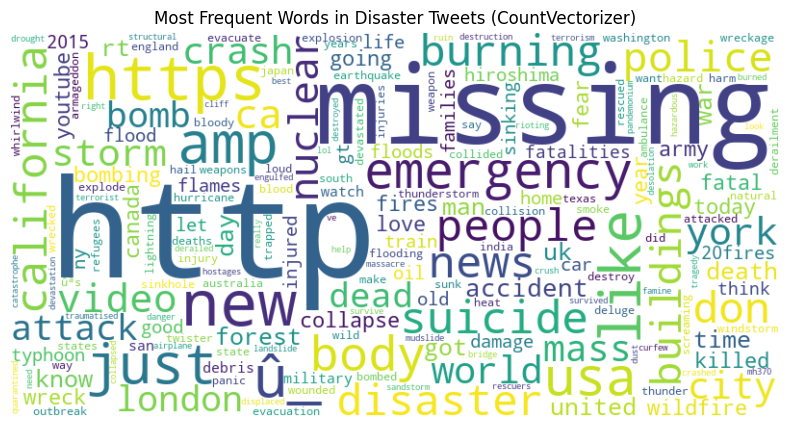

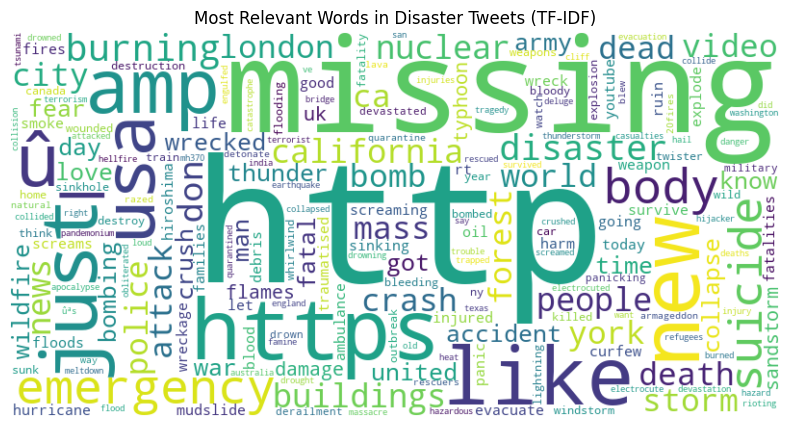

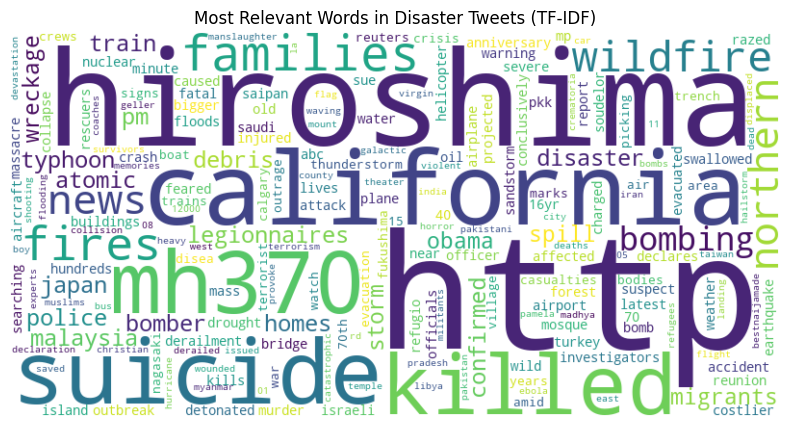

In [ ]:
# Create a word cloud from the most frequent words (count)
wordcloud_count = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(word_freq_df['word'], word_freq_df['count'])))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_count, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Disaster Tweets (CountVectorizer)")
plt.show()

# Create a word cloud from the most relevant words (tfidf)
wordcloud_tfidf = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(tfidf_df['word'], tfidf_df['tfidf'])))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_tfidf, interpolation="bilinear")
plt.axis("off")
plt.title("Most Relevant Words in Disaster Tweets (TF-IDF)")
plt.show()

# Create a word cloud from the most differentiated words (difference)
wordcloud_difference = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(word_comparison_df['word'], word_comparison_df['difference'])))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_difference, interpolation="bilinear")
plt.axis("off")
plt.title("Most Differentiated Words in Real vs. Fake Disaster Tweets")
plt.show()